In this notebook, we are solving the given binary classification problem as a part of Wolt hiring take home assignment.

**Author:** *Manish Saraswat*  
**Date:** *17.04.2023*

### Table of Contents

1. [Import Libraries](###-1.-Import-Libraries)
2. [Loading Data](###-2.-Loading-Data)
3. [Data Exploration](###-3.-Data-Exploration)
    * 3.1 *Univariate Analysis*
    * 3.2 *Multivariate Analysis*
4. [Feature Engineering](###-4.-Feature-Engineering)
5. [Split the data](###-5.-Split-the-data)
6. [Model Training](###-6.-Model-Training)
    * 6.1 *Logistic Regression*
    * 6.2 *Random Forest*
    * 6.3 *Catboost*
    * 6.4 *Ensemble Predictions*
7. [Further Efforts](###-7.-Further-Efforts)

--------

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import catboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.calibration import calibration_curve

%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------

### 2. Loading Data

Lets load the given data set and how much data we have for modeling.

In [2]:
df = pd.read_csv('/drive-download-20230413T155515Z-001/data_science_assignment_data.csv')

In [3]:
df.shape

(10000, 6)

In [4]:
df.head()

,date,numeric0,numeric1,categorical0,time,target
0,2015-11-24,2515,2.0,c,01:33:52,0
1,2009-03-05,5156,NaN,b,20:09:27,0
2,2015-12-23,5930,NaN,b,11:22:35,0
3,1992-02-16,2967,NaN,b,19:18:36,0
4,1971-06-06,194,5.0,c,20:01:58,0


In [5]:
df.target.value_counts(normalize=True)

0    0.867
1    0.133
Name: target, dtype: float64

**Observations:** 

* We find the data consists of numeric, categorical and time based features. This hints at the need to do some additional feature transformations in the following steps.
* The given data has just 10k rows, easily manageable to work with on a local machine. 
* The features are anonymised, hence difficult to relate to how the data is generated, but we can definitely do some feature engineering.
* The given data is imbalanced with only 13.3% positive samples. There are several techniques to handle class imbalance such as oversampling, undersampling etc. In this notebook, we'll use class weighting strategy to tackle class imbalance.

--------

### 3. Data Exploration

Here we'll do feature transformation and try to understand if we can find some patterns in the given set of features.

In [6]:
def extract_time_features(df: pd.DataFrame):
    """Create features for exploration and modeling"""
    df['time_format'] = pd.to_timedelta(df['time'])
    df['date'] = pd.to_datetime(df['date'])
    
    # extract hour, min, seconds from time feature
    df[['hour', 'minute', 'seconds']] = df['time'].str.split(':').tolist()
    df['hour'] = df['hour'].astype(int)
    df['minute'] = df['minute'].astype(int)
    df['seconds'] = df['seconds'].astype(int)
    
    return df

In [7]:
df = extract_time_features(df)

#### 3.1 **Lets start by univariate analysis. Here we'll explore one feature at a time and understand its distribution.**

<AxesSubplot: title={'center': 'Missing values per feature'}>

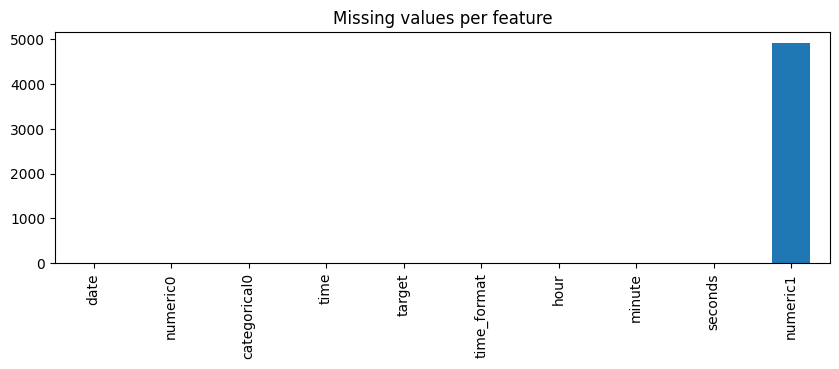

In [8]:
df.isna().sum().sort_values().plot(kind='bar', figsize=(10, 3), title='Missing values per feature')

<AxesSubplot: title={'center': 'Num samples by hour'}, xlabel='time_format'>

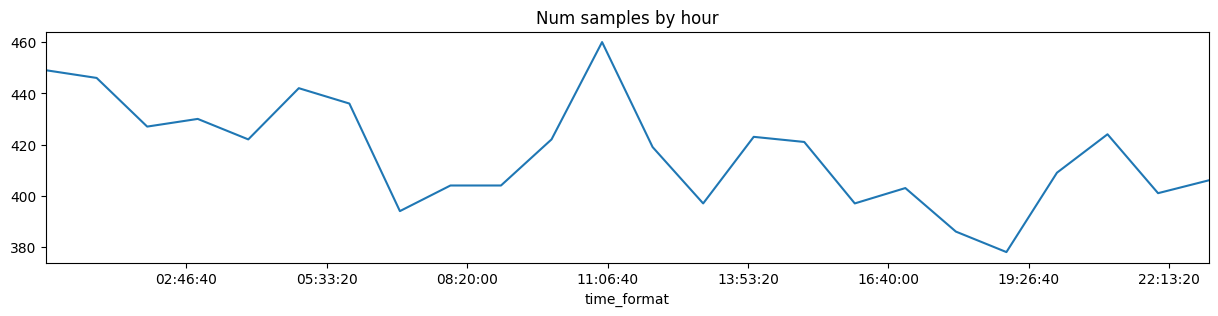

In [9]:
df.set_index('time_format').resample('H').size().plot(figsize=(15, 3), title='Num samples by hour')

<AxesSubplot: >

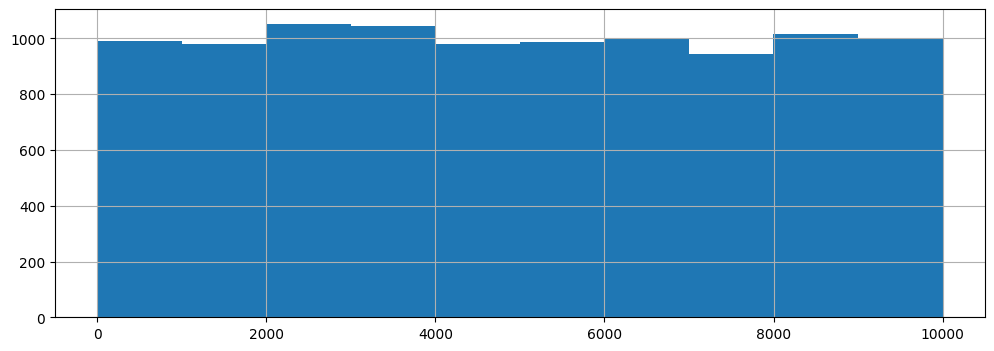

In [10]:
df['numeric0'].hist(figsize=(12, 4)) 

<AxesSubplot: title={'center': 'Num samples by numeric1'}>

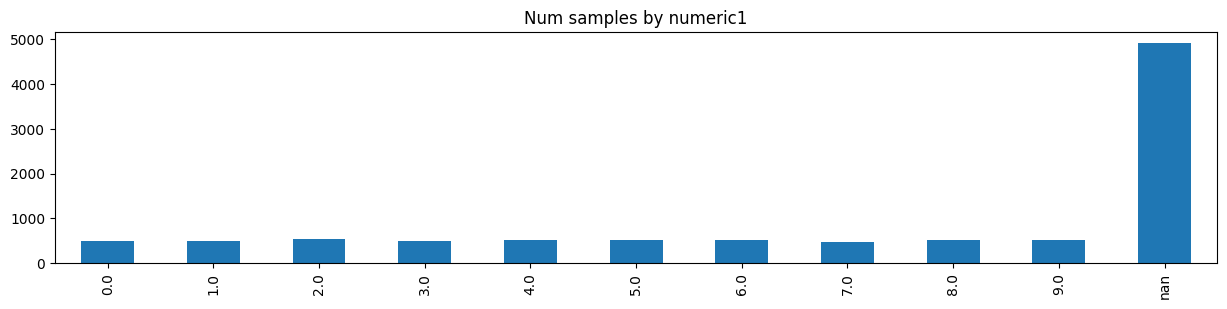

In [11]:
df['numeric1'].value_counts(dropna=False).sort_index().plot(kind='bar', figsize=(15, 3), title='Num samples by numeric1')

**Observations:** 

* Only one feature `numeric1` has NA values. 
* We find the peak of number of samples comes around `11am` and the dip is showing at `7:30pm`. `time` feature contains timestamp for a particular day.
* `numeric0` feature is uniformly distributed.
* `numeric1` feature have only integer values. Values seems to be equally distributed across all values. 

#### 3.2 **Lets do multi-variate analysis and investigate if any patterns are emerging from a combination of features.**

<AxesSubplot: title={'center': 'Num samples by target per year'}, xlabel='date'>

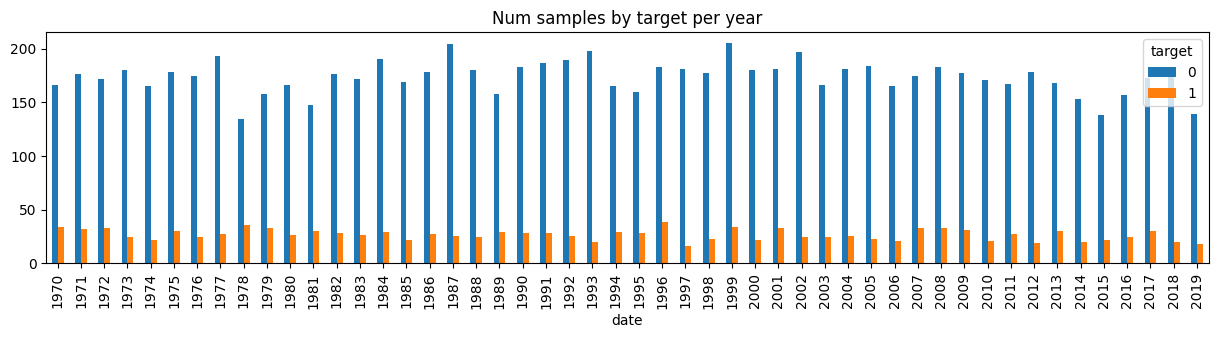

In [12]:
df.groupby([df['date'].dt.year, df['target']]).size().unstack().plot(kind='bar', figsize=(15, 3), title='Num samples by target per year')

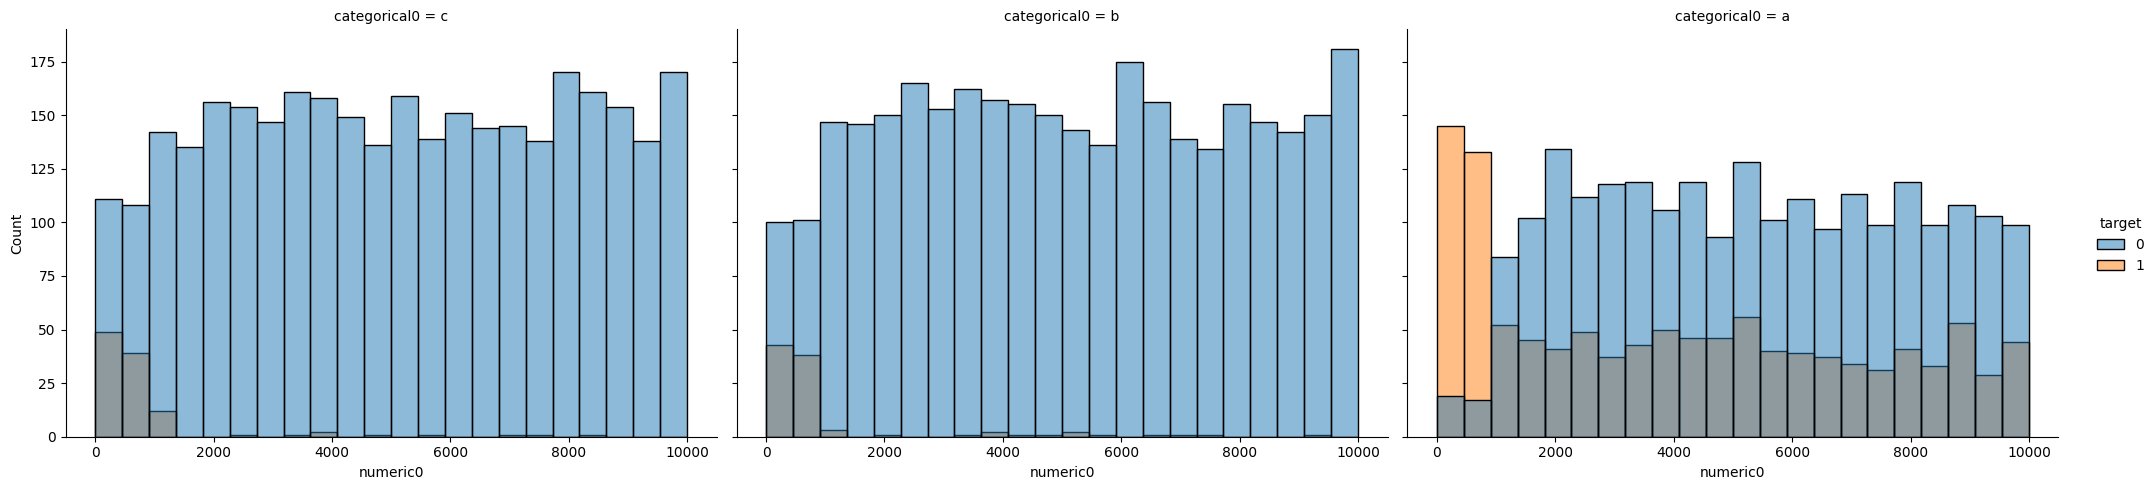

In [13]:
# showing distribution of numeric0 over categorical0 feature partitioned by target variable
sns.displot(data=df, x='numeric0', hue='target', aspect=1.4, height=5, col='categorical0')

<AxesSubplot: xlabel='minute', ylabel='hour'>

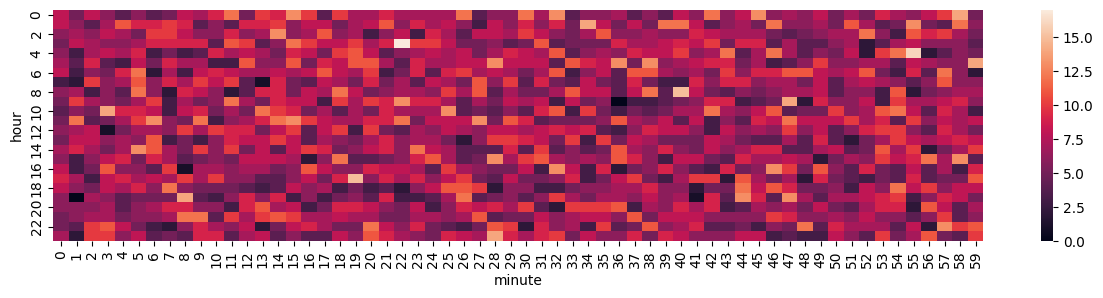

In [14]:
# check the distribution of samples across hour and minutes of the day
plt.figure(figsize=(15, 3))
sns.heatmap(pd.crosstab(df['hour'], df['minute']),)

In [15]:
# features correlation plot
def gradient(val):
    
    if abs(val) == 1.0:
        return 'background-color: red'
    elif abs(val) > 0.1 and abs(val) < 1.0:
        return 'background-color: purple'
    return 'background-color: black'
    
df.select_dtypes(include=['float', 'int']).corr().style.applymap(gradient)

,numeric0,numeric1,target,hour,minute,seconds
numeric0,1.000000,0.010304,-0.189356,-0.010245,0.000417,-0.007622
numeric1,0.010304,1.000000,0.009822,0.009912,-0.022613,0.006247
target,-0.189356,0.009822,1.000000,0.015189,0.005091,-0.019217
hour,-0.010245,0.009912,0.015189,1.000000,0.006978,0.006334
minute,0.000417,-0.022613,0.005091,0.006978,1.000000,-0.000003
seconds,-0.007622,0.006247,-0.019217,0.006334,-0.000003,1.000000


**Observations:** 

* We see the target distribution across years don't show a clear trend. Earlier vs recent years seems to similarly contribute to the target variable. 
* We see the multivariate plot of `categorical0` and `numeric0` depicts a strong feature split. We learn `categorical0=a` and lower values of `numeric0` features have higher contribution to the positive class. This means doing one hot encoding of the `categorical0` feature might help.
* The correlation plot depicts a significant correlation of `numeric0` feature with the target variable.

Our analysis until now has given us a couple of ideas which can be used to create additional features.

--------

### 4. Feature Engineering

In [16]:
def create_features(df: pd.DataFrame):
    """Create additionals features for modeling."""
    # dummy feature to represent NA value
    df['numeric1_imputed'] = df['numeric1'].fillna(-1)
    # need to encode cat feature as one hot encoded so it can be used in logistic regression model
    df = pd.concat([df,pd.get_dummies(df['categorical0'], prefix='feat')], axis=1)
    # need to encode cat feature as multi categorical to be used by random forest model
    df['cat_en'] = pd.factorize(df['categorical0'])[0]
    #  derived interaction feature
    df['num0_div_1'] = (df['numeric0'] / df['numeric1']).fillna(-1)
    df['num0_div_1'] = df['num0_div_1'].replace(float('inf'),-1)
    # track the age of a sample
    df['age'] = pd.Timestamp('now').year - df['date'].dt.year
    # categorize hour into four buckets: morning, lunch, evening, night
    df['day_period'] = pd.cut(df['hour'].astype(int), bins=[-1,6,12,18,25], labels=False)
    return df

df = create_features(df)    

--------

### 5. Split the data
Here we do stratified sampling to ensure the target distribution is maintained in train and validation set. Ideally, besides train and validation, we should create a holdout set as well (in total 3) to evaluate the model performance, but for this problem we'll use only two sets.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df['target'], 
                                                    test_size=0.3, 
                                                    stratify=df['target'],
                                                    random_state=42, 
                                                    shuffle=True)
X_train.shape, X_test.shape

((7000, 18), (3000, 18))

--------

### 6. Model Training

In this section, we'll start with building a baseline model using logistic regression. Having a baseline model, helps us understand what we can achieve using minimal efforts, and how much improvement can we expect using more advanced algorithm.


#### 6.1 Logistic Regression

In [18]:
cols = ['numeric0','hour', 'minute', 'seconds', 'numeric1_imputed','num0_div_1', 'age', 'feat_a', 'feat_b', 'feat_c']
lr=LogisticRegression(max_iter=1000, class_weight={0:1, 1: int(y_train.shape[0]/sum(y_train))})
lr.fit(X_train[cols], y_train)

LogisticRegression(class_weight={0: 1, 1: 7}, max_iter=1000)

In [19]:
pred_lr = lr.predict(X_test[cols])
pred_prob_lr = lr.predict_proba(X_test[cols])[:,1]

<AxesSubplot: >

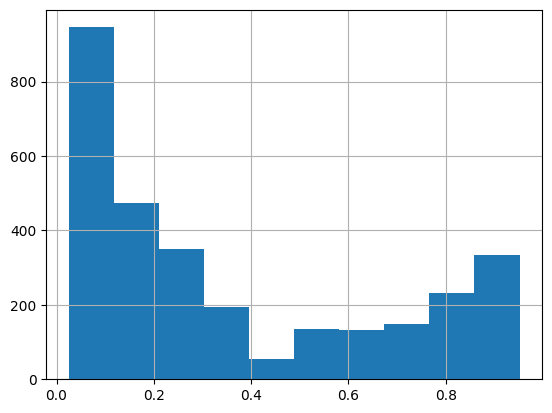

In [20]:
# lets visualise the probability distribution
pd.Series(pred_prob_lr).hist()

In [21]:
print(metrics.classification_report(y_test, pred_lr))
print(f'AUC Score = {metrics.roc_auc_score(y_test, pred_prob_lr):.5}')
print(f'F1 Score = {metrics.f1_score(y_test, pred_lr):.5}')

              precision    recall  f1-score   support

           0       0.96      0.75      0.84      2601
           1       0.33      0.79      0.46       399

    accuracy                           0.76      3000
   macro avg       0.64      0.77      0.65      3000
weighted avg       0.88      0.76      0.79      3000

AUC Score = 0.86435
F1 Score = 0.46413


#### 6.2 Random Forest

In [22]:
rf = RandomForestClassifier(random_state=42,
                            n_estimators=500,
                            class_weight={0:1, 1: int(y_train.shape[0]/sum(y_train))},  
                            max_depth=6).fit(X_train[cols], y_train)

In [23]:
pred_rf = rf.predict(X_test[cols])
pred_prob_rf = rf.predict_proba(X_test[cols])[:,1]

In [24]:
print(metrics.classification_report(y_test, pred_rf))
print(f'AUC Score = {metrics.roc_auc_score(y_test, pred_prob_rf):.5}')
print(f'F1 Score = {metrics.f1_score(y_test, pred_rf):.5}')

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      2601
           1       0.32      0.93      0.47       399

    accuracy                           0.72      3000
   macro avg       0.65      0.81      0.64      3000
weighted avg       0.90      0.72      0.77      3000

AUC Score = 0.85055
F1 Score = 0.47335


In [25]:
# check dependence plots
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test[cols])

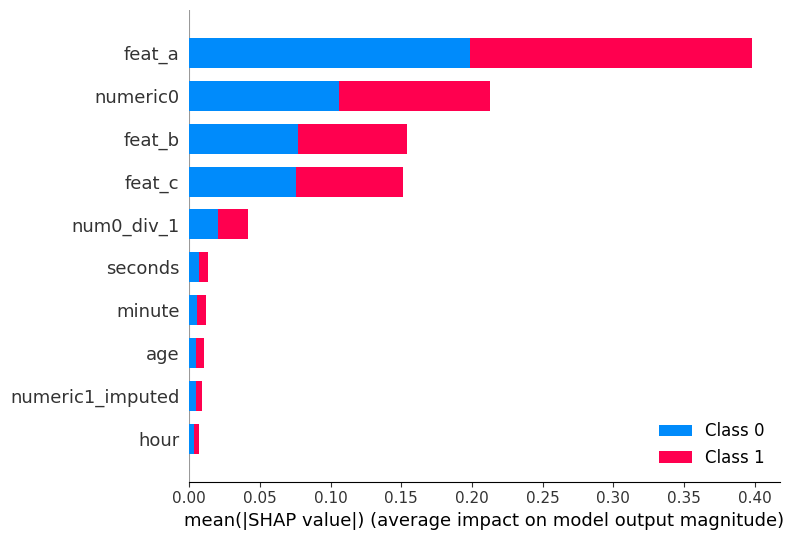

In [26]:
shap.summary_plot(shap_values, X_test[cols], max_display=10)

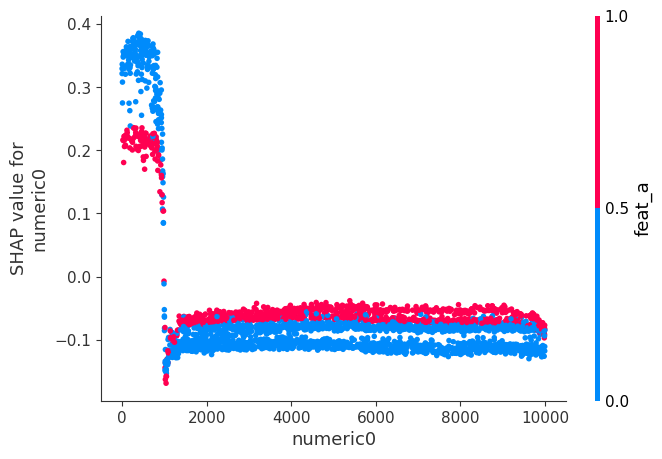

In [37]:
shap.dependence_plot(0, shap_values[1], X_test[cols])

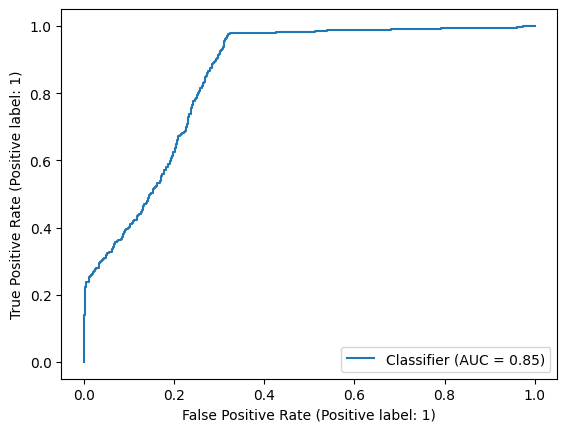

In [36]:
metrics.RocCurveDisplay.from_predictions(X_test['target'], pred_prob_rf) 

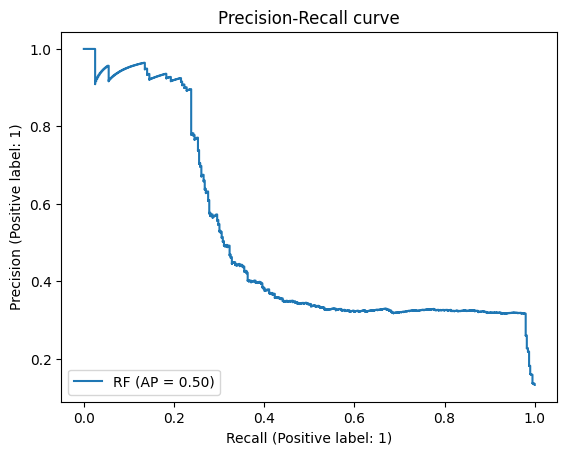

In [37]:
display = metrics.PrecisionRecallDisplay.from_predictions(X_test['target'], pred_prob_rf, name="RF")
_ = display.ax_.set_title("Precision-Recall curve")

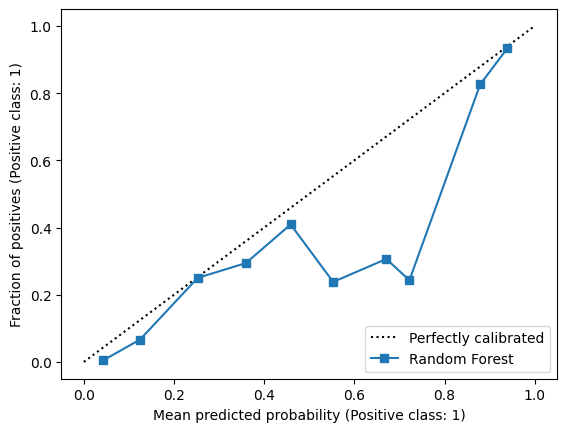

In [46]:
CalibrationDisplay.from_predictions(X_test['target'], pred_prob_rf, n_bins=10, name='Random Forest')

#### 6.3 Catboost

In [44]:
cb = catboost.CatBoostClassifier(scale_pos_weight=sum(y_train == 0)/sum(y_train == 1))

In [ ]:
cb.fit(X_train[cols], y_train)

In [46]:
pred_cb= cb.predict(X_test[cols])
pred_prob_cb = cb.predict_proba(X_test[cols])[:,1]

In [47]:
print(metrics.classification_report(y_test, pred_cb))
print(f'AUC Score = {metrics.roc_auc_score(y_test, pred_prob_cb):.5}')
print(f'F1 Score = {metrics.f1_score(y_test, pred_cb):.5}')

              precision    recall  f1-score   support

           0       0.95      0.76      0.85      2601
           1       0.33      0.76      0.46       399

    accuracy                           0.76      3000
   macro avg       0.64      0.76      0.66      3000
weighted avg       0.87      0.76      0.80      3000

AUC Score = 0.86023
F1 Score = 0.46201


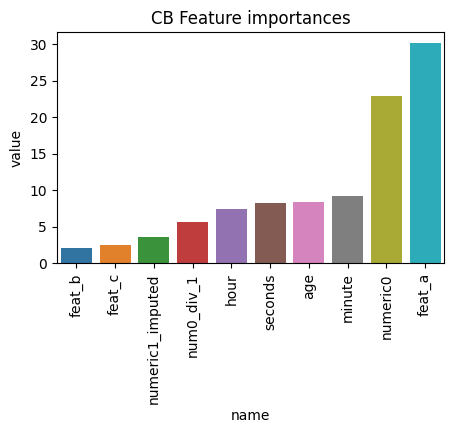

In [49]:
plt.figure(figsize=(5, 3))
impdf = pd.DataFrame({'name': cb.feature_names_, 'value': cb.feature_importances_}).sort_values('value')
g = sns.barplot(x=impdf['name'], 
                y=impdf['value'])
g.set_title("CB Feature importances");  
_=plt.xticks(rotation=90)

**Observations**:

* Since this is an imbalanaced classification problem, we look at non accuracy metrics to evaluate the model performance. Here, we are checking `AUC` metric along with `Precision`, `Recall`, `F1` metrics. Combination of these metrics tend to provide a more clearer picture of the model performance.
* To handle imbalance, we use class weighting strategy. Here, we weight positive samples higher than negatives. The weight used is inversely proportional to the positive samples available in the data set.
* We find, Random Forest performs the best with F1 score 2% higher than Logistic Regression. Also, `Recall` for random forest is approx 17% higher than `Logistic Regression` with almost same precision. 
* However, considering the simplicity of deploying models, Logistic Regression also provides a decent start. 
* *ROC Curve* and *PR AUC* Curve helps us better understand the distribution of model performance at different thresholds. 
* We used *shap values* plot to understand the contribution of a particular feature on target variable. In the plot above, we see the lower values of `numeric0` increases the probability of a sample belonging to class 1.
* From *Calibration Plot*, we see the model tends to be overconfident for a samples of data. 

#### 6.4 Ensemble Predictions

Ensemble technique is used to combine multiple model predictions to generate a final outcome. Ideally, the models used for ensembling should be as diverse (un-correlated) as possible. For this problem, we'll use logistic regression and random forest for ensembling. 

In [41]:
pred_prob_ens = (pred_prob_rf + pred_prob_lr)/2
pred_ens = np.where(pred_ens_prob >= 0.5, 1, 0)

In [42]:
print(metrics.classification_report(y_test, pred_ens))
print(f'AUC Score = {metrics.roc_auc_score(y_test, pred_prob_ens):.5}')
print(f'F1 Score = {metrics.f1_score(y_test, pred_ens):.5}')

              precision    recall  f1-score   support

           0       0.98      0.71      0.83      2601
           1       0.32      0.88      0.47       399

    accuracy                           0.74      3000
   macro avg       0.65      0.80      0.65      3000
weighted avg       0.89      0.74      0.78      3000

AUC Score = 0.86405
F1 Score = 0.47256


**Observations**

* Ensemble predictions aren't any better than the random forest model. 

--------

### 7. Further Efforts

Given more time, performing following steps also helps in improving the model performance:

* **Error Analysis**: This is done to understand the False Positives/False Negatives distribution of the prediction. We must understand under which samples models is making mistakes.
* **Hyperparameter Tuning**: Using randomised search/grid search we can find optimal parameters for model training.
* **Cross Validation**: Using out of fold cross validation, we can understand the variance in the model performance. This is done to establish a confidence interval for the model metrics. 
* **Balance Dataset**: Try with undersampling, oversampling technique and train the model on a balanced data set.
* **Probability Calibration**: Probabilites should be calibrated inorder to ensure the model doesn't underpredict or overpredict at extreme. 

-------------------------